## Imports

In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.instruction import Instruction
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.states import Statevector
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Estimator

import numpy as np
from numpy.linalg import eig, norm
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from itertools import combinations, chain
from heapq import nsmallest

C:\Users\Ittay\AppData\Local\Temp\ipykernel_15420\433787005.py:6: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import VQE


In [2]:
NUM_STATES_2_QUBITS = 4
NUM_MUBS_2_QUBITS = 5
NUM_STATES_3_QUITS = 8
NUM_MUBS_3_QUBTIS = 9

## Generate transverse-field Ising operator

I started by using the qiskit_nature.second_q module. That proved to be a mistake once I want to move to qubits,
because their move is not trivial.

The following is an implementation of the operators in SparsePauliOp form directly.

In [3]:
def gen_trans_ising_op(num_qubits: int, zz_coeff: float, x_coeff: float, toric_bounds: bool=False) -> SparsePauliOp:
    terms = []
    coeffs = []
    # Adding the ZZ terms
    for i in range(num_qubits if toric_bounds else num_qubits-1):
        curr_term = ['I'] * num_qubits
        curr_term[i] = 'Z'
        curr_term[(i+1)%num_qubits] = 'Z'
        terms.append(''.join(curr_term))
        coeffs.append(zz_coeff)
    # Adding the X terms
    for i in range(num_qubits):
        curr_term = ['I'] * num_qubits
        curr_term[i] = 'X'
        terms.append(''.join(curr_term))
        coeffs.append(x_coeff)
    
    return SparsePauliOp(terms, coeffs)

## Get exact answers

### A question of goals
In the origianl formulation, the goal of VQE is to find the lowest eigenvalue.
The tricky part is that numpy does not guarantee any ordering of the eigenvalues and eigenvectors. So that's on us.

In [4]:
def get_exact_ground(op: SparsePauliOp) -> np.float64:
    eig_res = eig(op.to_matrix())
    return min(eig_res.eigenvalues).real

## Get expectation value over specific state-vector

In [5]:
def get_expectation_value(state: Statevector, op: SparsePauliOp) -> np.float64:
    return np.round(state.expectation_value(op).real, 10)

## Generate MUB statevectors
This is done using Dekel's current notebook code.
The code is, for lack of a better word, bad.
I will attempt to prepare it in a cleaner and more robust way.
But for now, let's check that the most basic way still works.

In [6]:
# Adds Y-Hadamard gate on qubit q in circ
def yh(circ, q):
    circ.h(q)
    circ.s(q)

def prep_MUB(circ, state_idx, mub_idx, qubit_subset = [0,1]):
    assert len(qubit_subset) == 2
    assert (0 <= state_idx <= 3)
    assert (0 <= mub_idx <= 4)
    # state_idx chooses the state in the basis (MUB)
    if state_idx == 1:
        circ.x(qubit_subset[0])
    elif state_idx == 2:
        circ.x(qubit_subset[1])
    elif state_idx == 3:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[1])
        
    # mub_idx chooses the basis (MUB) itself
    if mub_idx == 1:
        circ.h(qubit_subset[0])
        circ.h(qubit_subset[1])
    elif mub_idx == 2:
        circ.h(qubit_subset[0])
        yh(circ,qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[1])
    elif mub_idx == 3:
        yh(circ,qubit_subset[0])
        yh(circ,qubit_subset[1])
    elif mub_idx == 4:
        yh(circ,qubit_subset[0])
        circ.h(qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[1])
        
def prep_MUB3(circ, state_idx, mub_idx, qubit_subset = [0,1,2]):
    # state_idx chooses the state in the basis (MUB)
    if state_idx == 1:
        circ.x(qubit_subset[0])
    elif state_idx == 2:
        circ.x(qubit_subset[1])
    elif state_idx == 3:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[1])
    elif state_idx == 4:
        circ.x(qubit_subset[2])
    elif state_idx == 5:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[2])
    elif state_idx == 6:
        circ.x(qubit_subset[1])
        circ.x(qubit_subset[2])
    elif state_idx == 7:
        circ.x(qubit_subset[0])
        circ.x(qubit_subset[1])
        circ.x(qubit_subset[2])
    
    # mub_idx chooses the basis (MUB) itself
    if mub_idx == 1:
        circ.h(qubit_subset[0])
        circ.h(qubit_subset[1])
        circ.h(qubit_subset[2])
    elif mub_idx == 2:
        yh(circ, qubit_subset[0])
        yh(circ, qubit_subset[1])
        yh(circ, qubit_subset[2])
    elif mub_idx == 3:
        yh(circ, qubit_subset[0])
        circ.h(qubit_subset[1])
        circ.h(qubit_subset[2])
        circ.cz(qubit_subset[1], qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
    elif mub_idx == 4:
        circ.h(qubit_subset[0])
        yh(circ, qubit_subset[1])
        circ.h(qubit_subset[2])
        circ.cz(qubit_subset[1], qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 5:
        circ.h(qubit_subset[0])
        circ.h(qubit_subset[1])
        yh(circ, qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 6:
        yh(circ, qubit_subset[0])
        yh(circ, qubit_subset[1])
        circ.h(qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 7:
        yh(circ, qubit_subset[0])
        circ.h(qubit_subset[1])
        yh(circ, qubit_subset[2])
        circ.cz(qubit_subset[1], qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[2])
    elif mub_idx == 8:
        circ.h(qubit_subset[0])
        yh(circ, qubit_subset[1])
        yh(circ, qubit_subset[2])
        circ.cz(qubit_subset[0], qubit_subset[1])
        circ.cz(qubit_subset[1], qubit_subset[2])

The field `state_idx` chooses the state *inside* the MUB.  
The field `mub_idx` chooses the basis.   
The field `qubit_subset` chooses the subset of qubit_subset over which to generate the MUB state.   

In [7]:
def generate_mub_state(state_idx: int, mub_idx: int, num_qubits: int, qubit_subset: list[int],
                        plus_for_non_mub=False) -> tuple[QuantumCircuit, np.ndarray]:
    circuit = QuantumCircuit(num_qubits)
    if len(qubit_subset) == 2:
        prep_MUB(circuit, state_idx, mub_idx, qubit_subset)
    elif len(qubit_subset) == 3:
        prep_MUB3(circuit, state_idx, mub_idx, qubit_subset)
    else:
        raise Exception("We do not support this size of MUB states.")
    if plus_for_non_mub:
        for qubit in range(num_qubits):
            if qubit not in qubit_subset:
                circuit.h(qubit)
    state = Statevector.from_instruction(circuit)
    return circuit, state

# Attempt all states over a hamiltonian

## Result heirarchy
The list heirarchy is defined by the following indexes, in this order:
1. MUB used.
2. Subset of qubits on which this MUB was applied.
3. The specific MUB states.

In [8]:
def generate_all_subsets(n_mub_qubits: int, n_qubits: int) -> list[tuple[int]]:
    return list(combinations(np.linspace(0, n_qubits-1, n_qubits, dtype=int), n_mub_qubits))

In [9]:
ResultTuple = tuple[QuantumCircuit, np.float64]
LandscapeResultsType = list[list[list[ResultTuple]]]

def calculate_energy_landscape(op: SparsePauliOp, n_mub_qubits: int, subset_list: list[tuple],
                                plus_for_non_mub=False) -> LandscapeResultsType:
    num_states = num_mubs = 0
    if n_mub_qubits == 2:
        num_states = NUM_STATES_2_QUBITS
        num_mubs = NUM_MUBS_2_QUBITS
    elif n_mub_qubits == 3:
        num_states = NUM_STATES_3_QUITS
        num_mubs = NUM_MUBS_3_QUBTIS
    else:
        raise Exception("We do not support this size of MUB states.")

    total_res = []
    for mub_idx in range(num_mubs):
        mub_res = []
        for subset in subset_list:
            subset_res = []
            for state_idx in range(num_states):
                circuit, state = generate_mub_state(state_idx, mub_idx, op.num_qubits, subset, plus_for_non_mub)
                res = get_expectation_value(state, op)
                subset_res.append((circuit, res))
            mub_res.append(subset_res)
        total_res.append(mub_res)
    return total_res

def flatten_results(results: LandscapeResultsType) -> list[ResultTuple]:
    flat_res = []
    for mub_res in results:
        for subset_res in mub_res:
            flat_res += subset_res
    return flat_res

def flatten_energies(results: LandscapeResultsType) -> list[np.float64]:
    flat_res = flatten_results(results)
    return [energy for circuit, energy in flat_res]

### Result Selection Code

In [10]:
def find_k_best_results(results: LandscapeResultsType, k: int) -> list[ResultTuple]:
    results = flatten_results(results)
    return sorted(results, key=(lambda x: x[1]))[:k]

## Graph display code

In [11]:
FIG_SIZE = (8,5)
def display_energy_landscape(energy_landscape_results: LandscapeResultsType, exact_result: np.float64, graph_title="Energy landscape",
                                show_legend=False):
    fig = plt.figure(figsize=FIG_SIZE)
    idx_counter = 0
    basis_size = len(results[0][0])
    mub_results_size = basis_size * len(results[0])
    for i, mub_res in enumerate(results):
        for j, subset_res in enumerate(mub_res):
            energies_only = [energy for circuit, energy in subset_res]
            plt.plot(list(range(idx_counter, idx_counter+basis_size)), energies_only, 'o', lw=0.4, label=f"MUB {i}, subset {j}")
            idx_counter += basis_size
        # Show separation between different MUBs
        plt.axvspan(idx_counter - mub_results_size, idx_counter, alpha=0.1, color=f"C{i}")
    # Show exact result
    plt.axhline(y=exact_result, lw=0.6, color='red')
    # Show comp. basis specifically
    xmin, xmax, ymin, ymax = plt.axis()
    plt.text(x=basis_size*0.25, y=ymin + (ymax-ymin)*0.8, s='COMP', fontsize=10)
    
    plt.xlabel("MUB state index")
    plt.ylabel("Cost function result")
    if show_legend:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(graph_title)
    plt.show()

def display_energy_histogram(energy_landscape_results: LandscapeResultsType, exact_result: np.float64, bins=100,
                                graph_title="Energy landscape histogram", show_legend=False):
    fig = plt.figure(figsize=FIG_SIZE)
    plt.locator_params(axis='x', nbins=min(bins//2, 30), tight=True)
    plt.xticks(fontsize=10, rotation=60)
    plt.locator_params(axis='y', nbins=10)

    flat_results = flatten_energies(energy_landscape_results)
    plt.hist(flat_results, bins)
    # Show exact result
    plt.axvline(x=exact_result, lw=1, color='red')

    plt.xlabel("Cost function result")
    plt.ylabel("number of results")
    if show_legend:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(graph_title)
    plt.show()

## Example: generate operator, calculate landscape, show results

In [12]:
n_qubits = 2
n_mub_qubits = 2

zz_coeff = random.uniform(0,1)
x_coeff = random.uniform(0,1)
op = gen_trans_ising_op(n_qubits, zz_coeff, x_coeff)
print(f"attempting all MUB states over the operator {op}")
results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits))
exact_result = get_exact_ground(op)

attempting all MUB states over the operator SparsePauliOp(['ZZ', 'XI', 'IX'],
              coeffs=[0.39638934+0.j, 0.70621845+0.j, 0.70621845+0.j])


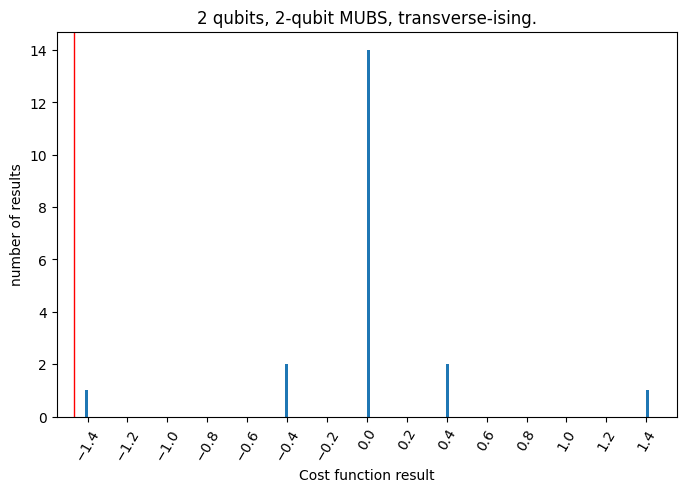

In [13]:
display_energy_histogram(results, exact_result, graph_title=f"{n_qubits} qubits, {n_mub_qubits}-qubit MUBS, transverse-ising.", bins=200)

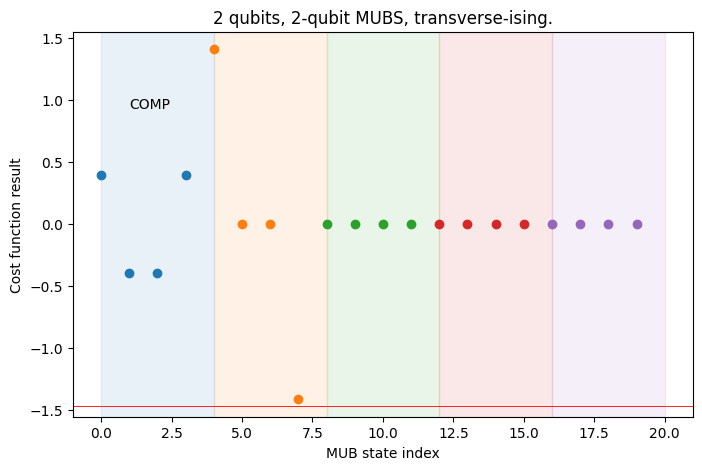

In [14]:
display_energy_landscape(results, exact_result, graph_title=f"{n_qubits} qubits, {n_mub_qubits}-qubit MUBS, transverse-ising.")

## Convincing results
What results dfo I want o show Tal and Dekel so they'll be convicned that what I did here shows anything?

1.  Show that when genrating 3-qubit full-MUB states using Trasnverse Ising, the best starting points are *clearly* not in the comp. basis.
    Do so by giving 2-3 examples of such generated Hamiltonians.

2.  Show that the rest of the results bunch around a VERY specific area in the cost, perhaps indicating a BP.
    Another, more pessimistic way to see this is that MUBs only give an advantage in a very small number of cases.
    Use the same graphs.

3.  Show that when we do Half-MUBs, the answers drastically drift away from the correct result. However, non-comps still lead to victory.
    Do so by giving 4-5 graphs with increasing qubit count, showing the distinct difference.

In [ ]:
# 3-qubit experiments
n_qubits = 3
n_mub_qubits = 3

for _ in range(3):  # Three examples
    zz_coeff = random.uniform(0,1)
    x_coeff = random.uniform(0,1)
    op = gen_trans_ising_op(n_qubits, zz_coeff, x_coeff)
    print(f"attempting all MUB states over the operator {op}")
    results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits))
    exact_result = get_exact_ground(op)
    print("Energy Landscape:")
    display_energy_landscape(results, exact_result=exact_result)
    print("Energy Histogram:")
    display_energy_histogram(results, exact_result=exact_result)

In [ ]:
# half-MUB experiments
n_mub_qubits = 3
zz_coeff = random.uniform(0,1)
x_coeff = random.uniform(0,1)

for n_qubits in range(4,8):  # Three examples

    op = gen_trans_ising_op(n_qubits, zz_coeff, x_coeff)
    print(f"attempting all MUB states over the operator {op}")
    results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits))
    exact_result = get_exact_ground(op)
    print("Energy Landscape:")
    display_energy_landscape(results, exact_result=exact_result)
    print("Energy Histogram:")
    display_energy_histogram(results, exact_result=exact_result)

### Unified results: partial-MUB with $\ket{0}$ vs. $\ket{+}$
Here, I run the same experiment with a bit less qubits, but use both options forn qubits not involved in the MUB state itself.
1.  Put it in $\ket{0}$, the trivial option.
2.  Put it in $\ket{+}$, the other option Dekel found to be rather successful.

In [ ]:
# half-MUB experiments
n_mub_qubits = 3
zz_coeff = random.uniform(0,1)
x_coeff = random.uniform(0,1)

print("THE ZERO EXPERIMENTS START")
for n_qubits in range(4,7):  # Three examples
    op = gen_trans_ising_op(n_qubits, zz_coeff, x_coeff)
    print(f"attempting all MUB states over the operator {op}")
    print("========ZERO VERSION=========")
    results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits))
    exact_result = get_exact_ground(op)
    print("Energy Landscape:")
    display_energy_landscape(results, exact_result=exact_result)
    print("Energy Histogram:")
    display_energy_histogram(results, exact_result=exact_result)
    print("========PLUS VERSION=========")
    results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits), plus_for_non_mub=True)
    exact_result = get_exact_ground(op)
    print("Energy Landscape:")
    display_energy_landscape(results, exact_result=exact_result)
    print("Energy Histogram:")
    display_energy_histogram(results, exact_result=exact_result)
    print("==============END============")


# Execute VQE
The Parameters class is taken from the old VQC project and adapted to this use case.

### Experiment Paremeters and Hyper-parameters

In [ ]:
from qiskit.quantum_info import Operator
ansatz = TwoLocal (
        params.n_qubits,
        ['ry','rz'],
        'crx',
        'linear',
        reps=params.n_layers
    )
print(Operator(ansatz.assign_parameters([0.0]*ansatz.num_parameters)).data)

In [15]:
class Parameters:
    def __init__(self, n_qubits: int, n_layers: int, optimizer: str, tol: float, success_bound: float, max_iter: int, exact_result: float|None = None):
        self.n_qubits = n_qubits            # number of qubist in the operator
        self.n_layers = n_layers            # number of ansatz layers
        self.optimizer = optimizer          # name of optimizer
        self.tol = tol                      # optimizer "tolerance" parameter. Semantic meaning differs between optimizers.
        self.success_bound = success_bound  # distance from exact result that we consider as success.
        self.max_iter = max_iter            # iteration bound
        self.exact_result = exact_result    # the exact result that we compare ourselves to.


def get_standard_params(n_qubits: int) -> Parameters:
    return Parameters(n_qubits=n_qubits, n_layers=5, optimizer='COBYLA', tol=1e-6, success_bound=1e-3, max_iter=1000)

In [16]:
def run_vqe_experiment(hamiltonian: SparsePauliOp, initial_state: QuantumCircuit, params: Parameters) -> tuple[int, float, bool]:
    # preparing the VQE components
    estimator_obj = Estimator()  # Internal qiskit structure
    ansatz = TwoLocal (
        params.n_qubits,
        ['ry','rz'],
        'crx',
        'linear',
        reps=params.n_layers
    )
    optimizer_obj = COBYLA(
        maxiter = 1000, \
        tol = params.tol \
    )
    # enforcing the success bound
    class BoundHitException(Exception):
        def __init__(self, n_evals, final_cost):
            self.n_evals = n_evals
            self.final_cost = final_cost
    def callback(eval_count: int, theta: np.ndarray, cost: float, metadata: dict) -> None:
        if params.exact_result is None:
            return
        if (eval_count % 10 == 0):
            print(f"{eval_count}: {cost}")
        if (cost < params.exact_result + params.success_bound):
            raise BoundHitException(eval_count, cost)
    
    try:
        vqe_obj = VQE(estimator=estimator_obj, ansatz=ansatz, optimizer=optimizer_obj, callback=callback, initial_point = [0.0]*ansatz.num_parameters)
        res = vqe_obj.compute_minimum_eigenvalue(operator=hamiltonian)
        return res.cost_function_evals, res.optimal_value, False
    except BoundHitException as e:
        return e.n_evals, e.final_cost, True

## Combined Example

Generate an operator, fins its landscape and histogram, then run VQE from the best 5 examples.

Energy Landscape:


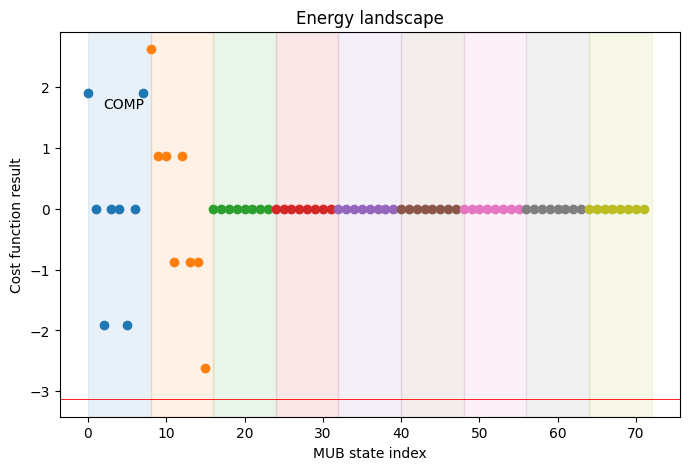

Energy Histogram:


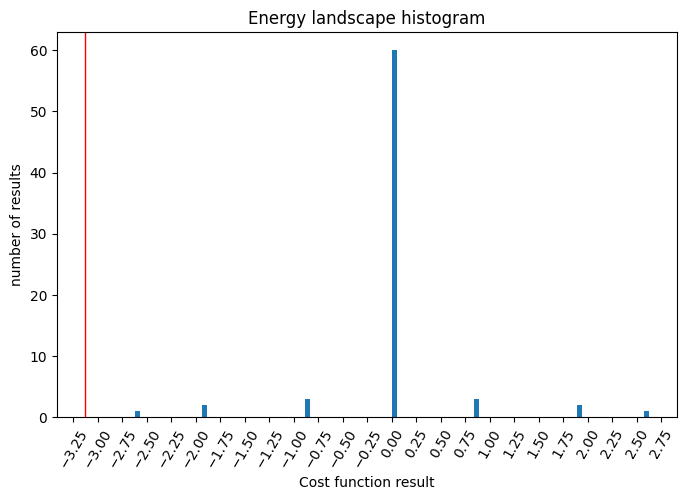

running from point with value -2.6200529228
10: 1.9234289733036087
20: 0.41220368590635825
30: -0.8651655089419805
40: -0.9892371766745915
50: -2.2760066572709947
60: -2.6186625913916797
70: -2.636249314691251
80: -2.498525033458117
90: -2.5348803094755286
100: -2.731598791203166
110: -2.6826485236886874
120: -2.7507900589259466
130: -2.753085103318571
140: -2.6395822772409763
150: -2.7936044533675854
160: -2.8439191911326023
170: -2.8706827125717203
180: -2.859161325454324
190: -2.876463275566544
200: -2.873738624935549
210: -2.8746387413679773
220: -2.873808676874439
230: -2.8762857926461556
240: -2.88449474924389
250: -2.8801609607182925
260: -2.890317888299182
270: -2.8934608274595015
280: -2.893300809567512
290: -2.8955225204932855
300: -2.897400647518544
310: -2.9054464583099913
320: -2.908835070387159
330: -2.9132506695558615
340: -2.9184273480008667
350: -2.924977411474774
360: -2.9342258842454205
370: -2.9335206577069037
380: -2.9357244619708256
390: -2.937044169462299
400: -2

KeyboardInterrupt: 

In [17]:
# generate operator
n_qubits = 3
n_mub_qubits = 3
x_coeff = random.uniform(0,1)
zz_coeff = random.uniform(0,1)
op = gen_trans_ising_op(n_qubits, x_coeff, zz_coeff)
exact_result = get_exact_ground(op)

# calculate landscape and graphs
results = calculate_energy_landscape(op, n_mub_qubits, generate_all_subsets(n_mub_qubits, n_qubits))
exact_result = get_exact_ground(op)
print("Energy Landscape:")
display_energy_landscape(results, exact_result=exact_result)
print("Energy Histogram:")
display_energy_histogram(results, exact_result=exact_result)

# run VQE from the best 5 examples
params = get_standard_params(n_qubits)
params.success_bound = 1e-2
params.exact_result = exact_result
for initial_state, value in find_k_best_results(results, 5):
    print(f"running from point with value {value}")
    print(run_vqe_experiment(op, initial_state, params))
    print(params.exact_result)